# Plot results from weather-forecast-demo multi-cloud runs
This simple plotting notebook stores and plots results from multi-cloud runs of the weather-forecast-demo intermediate-size weather model benchmark.

**NOTE**: Although the results here show run times for individual clouds, they are **preliminary and incomplete**. In particular, there has been **no** effort to optimize the run times on any cloud - this means that run times will likely change significantly with systematic testing and judicious choice of instance types, regions, and other cloud infrastructure parameter choices.

## Data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set uniform font sizes based on
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

# Input data units of decimal minutes
# _nl => no Lustre
# _wl => with Lustre
# _p => published/public reported run time
c1_nl = [4.98, 4.92, 4.88, 4.88]
c1_wl = [4.67, 4.55, 4.55, 4.57]

# New instance type, no group placements
c1_nl_new_nogrp = [4.27825, 4.262, 4.340]
c1_wl_new_nogrp = [3.925, 3.976, 3.8791]

# New instance type, with group placements


c2_nl = [5.42, 4.98, 6.28, 4.85, 4.72, 4.72]
c2_wl = [4.23, 4.18, 4.18, 4.22]

c3_nl = [5.33, 6.25, 5.68, 5.40, 5.33, 5.40]
c3_wl = [4.80, 4.72, 4.78, 4.80]

aws_wl_p = [4.28]

# On-premise bare-metal
oprem_nl = [4.97, 4.98, 4.95]

cloud_nl = c1_nl + c2_nl + c3_nl
cloud_wl = c1_wl + c2_wl + c3_wl

## Results

[Text(1, 0, 'Cloud no Lustre'),
 Text(2, 0, 'Cloud w/ Lustre'),
 Text(3, 0, 'On-prem no Lustre'),
 Text(4, 0, '(Smith et al. 2022)')]

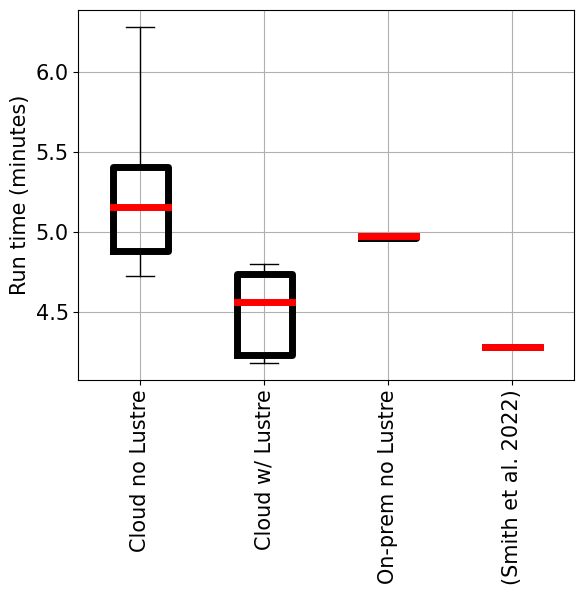

In [2]:
# Box formatting suggestions from: https://matplotlib.org/stable/gallery/statistics/boxplot.html
flierprops = dict(
    marker='o', 
    markerfacecolor='green', 
    markersize=12,
    markeredgecolor='none')

medianlineprops = dict(
    linestyle='-',
    linewidth=5, 
    color='red')

boxprops = dict(
    linestyle='-',
    linewidth=5,
    color='black')

# Plot run times
fig, ax = plt.subplots()
ax.boxplot([
    cloud_nl,
    cloud_wl,
    oprem_nl,
    aws_wl_p],
    boxprops=boxprops,
    flierprops=flierprops,
    medianprops=medianlineprops,
    whis=(0, 100)
    )
ax.set_ylabel('Run time (minutes)')
ax.grid()
ax.set_xticklabels(
    ['Cloud no Lustre', 
     'Cloud w/ Lustre', 
     'On-prem no Lustre', 
     '(Smith et al. 2022)'],
    rotation=90)

[Text(1, 0, 'Cloud 1 no Lustre'),
 Text(2, 0, 'Cloud 1 no Lustre, new inst.'),
 Text(3, 0, 'Cloud 2 no Lustre'),
 Text(4, 0, 'Cloud 3 no Lustre'),
 Text(5, 0, 'Cloud 1 w/ Lustre'),
 Text(6, 0, 'Cloud 1 w/ Lustre, new inst.'),
 Text(7, 0, 'Cloud 2 w/ Lustre'),
 Text(8, 0, 'Cloud 3 w/ Lustre'),
 Text(9, 0, 'On-prem no Lustre'),
 Text(10, 0, '(Smith et al. 2022)')]

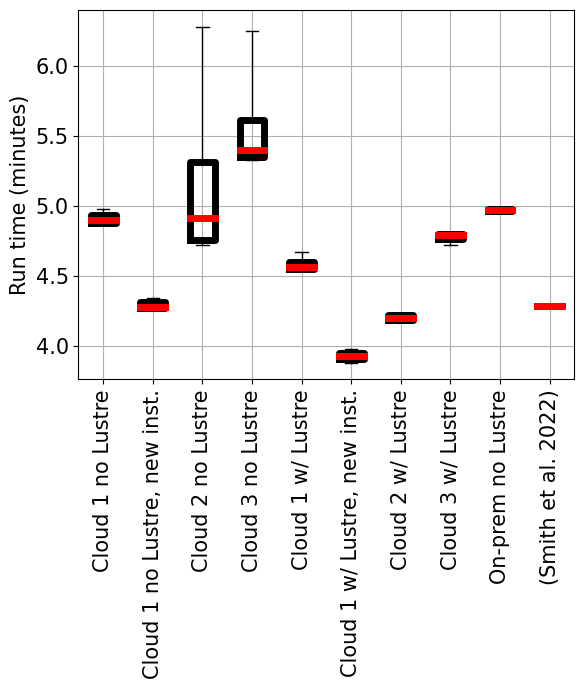

In [3]:
# Box formatting suggestions from: https://matplotlib.org/stable/gallery/statistics/boxplot.html
flierprops = dict(
    marker='o', 
    markerfacecolor='green', 
    markersize=12,
    markeredgecolor='none')

medianlineprops = dict(
    linestyle='-',
    linewidth=5, 
    color='red')

boxprops = dict(
    linestyle='-',
    linewidth=5,
    color='black')

# Plot run times
fig, ax = plt.subplots()
ax.boxplot([
    c1_nl,
    c1_nl_new_nogrp,
    c2_nl,
    c3_nl,
    c1_wl,
    c1_wl_new_nogrp,
    c2_wl,
    c3_wl,
    oprem_nl,
    aws_wl_p],
    boxprops=boxprops,
    flierprops=flierprops,
    medianprops=medianlineprops,
    whis=(0, 100)
    )
ax.set_ylabel('Run time (minutes)')
ax.grid()
ax.set_xticklabels(
    ['Cloud 1 no Lustre',
     'Cloud 1 no Lustre, new inst.',
     'Cloud 2 no Lustre',
     'Cloud 3 no Lustre',
     'Cloud 1 w/ Lustre',
     'Cloud 1 w/ Lustre, new inst.',
     'Cloud 2 w/ Lustre',
     'Cloud 3 w/ Lustre',
     'On-prem no Lustre', 
     '(Smith et al. 2022)'],
    rotation=90)